In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 11)  #set default figure size
import numpy as np
import os 
import pandas as pd
from ailearn.Swarm import ES
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, ConstantKernel as C
from sklearn.svm import SVC,SVR
from sklearn.metrics import mean_squared_error,r2_score
from scipy.optimize import leastsq
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn import preprocessing

C:\Users\mero_\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Important functions

In [2]:
## Seperate training and test data
def split(xx, yy):
    zscore = StandardScaler()        
    scaler =MinMaxScaler()   
    xx = zscore.fit_transform(xx)  
    yy = scaler.fit_transform(np.reshape(yy.values,(len(yy),1))) 
    x_train, x_test_val, y_train, y_test_val = train_test_split(xx, yy, shuffle=True,test_size=0.4, random_state=1)
    x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, shuffle=True,test_size=0.25, random_state=1)
    y2 = yy.ravel()
    ind_train = [np.argwhere(y2 == y_train[i])[0].item() for i in range(len(y_train)) if y_train[i] in y2]
    ind_test = [np.argwhere(y2 == y_test[i])[0].item() for i in range(len(y_test)) if y_test[i] in y2]
    ind_val = [np.argwhere(y2 == y_val[i])[0].item() for i in range(len(y_val)) if y_val[i] in y2]
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    y_val = y_val.ravel()
    return x_train, x_test,x_val, y_train, y_test,y_val, xx, yy, np.asarray(ind_train), np.asarray(ind_test), np.asarray(ind_val)

In [3]:
# inverse predictive values
def inverse_scaler(y_scaled, y_true):
    scaler =MinMaxScaler()   
    scaler.fit(np.reshape(yy.values,(len(yy),1))) 
    y_inverse = scaler.inverse_transform(y_scaled.reshape(-1,1))
    return y_inverse

### import data

In [9]:
df = pd.read_csv('data_6.csv', index_col=None, engine='c') 
print('original datasize:', df.shape)
df.dropna(inplace=True)
print('adjusted datasize:', df.shape)
print('data:')
print(df.head())

original datasize: (475, 11)
adjusted datasize: (474, 11)
data:
           Kd   SSA        C%       H/C       O/C     E     S     A     B  \
0   24.014337  0.04  0.683575  0.147232  0.157833  1.73  1.55  0.47  0.45   
1   37.981913  0.04  0.632581  0.139353  0.220736  1.73  1.55  0.47  0.45   
2   50.563768  0.04  0.592297  0.132170  0.278086  1.73  1.55  0.47  0.45   
3  103.582271  0.04  0.444276  0.094589  0.578131  1.73  1.55  0.47  0.45   
4   66.880171  0.04  0.654811  0.142939  0.192110  1.73  1.55  0.47  0.45   

        V   log(Kd)  
0  1.8088  1.380471  
1  1.8088  1.579577  
2  1.8088  1.703839  
3  1.8088  2.015285  
4  1.8088  1.825297  


In [10]:
yy=df.iloc[:,-1]# target - kd
xx= df.iloc[:,1:-1] # predictors
x_train, x_test,x_val, y_train, y_test,y_val, x_scaled, y_scaled, ind_train, ind_test,ind_val = split(xx, yy)


print('target is ', yy.name)
print('predictors are ', xx.columns.tolist())
print('samples size is ', xx.shape[0], '; number of predictors is ', xx.shape[1])
print('training data size is ', x_train.shape[0], '; test data size is ', x_test.shape[0],'; validation data size is ', x_val.shape[0])


target is  log(Kd)
predictors are  ['SSA', 'C%', 'H/C', 'O/C', 'E', 'S', 'A', 'B', 'V']
samples size is  474 ; number of predictors is  9
training data size is  284 ; test data size is  142 ; validation data size is  48


# Extreme Gradient Boosting

In [11]:
import pickle
# load gpr model
path='Models/'
model_name = 'xgbr.pkl'
with open(path+model_name,'rb') as f:
    xgbr = pickle.load(f)
y_pred_train = xgbr.predict(x_train)
y_pred_test = xgbr.predict(x_test)    
y_pred_val = xgbr.predict(x_val) 


# Gaussian Process Regression

In [16]:
import pickle
# load gpr model
path='Models/'
model_name = 'gpr.pkl'
with open(path+model_name,'rb') as f:
    gpr = pickle.load(f)
    
y_pred_train = gpr.predict(x_train)    
y_pred_test = gpr.predict(x_test)    
y_pred_val = gpr.predict(x_val) 


# Genetic algorithm - Support vector machine

In [17]:
import pickle
# load gpr model
model_name = 'GA_SVM.pkl'
with open(path+model_name,'rb') as f:
    ga_svm = pickle.load(f)
    
y_pred_train = ga_svm.predict(x_train)    
y_pred_test = ga_svm.predict(x_test)    
y_pred_val = ga_svm.predict(x_val)  

# Sensitivity analysis

In [18]:
def MSE(y_test, y_pred_test):
    
    return mean_squared_error(y_test, y_pred_test)

def SA_base_on_MSE(model, x_Model, y_Model):
    ### stepwise selection II is to set all values of one input variable to its mean (or others) 
    ### and examine the value of MSE under the change.

    SA = pd.Series(index = x_Model.columns, dtype='object'  ) # create a table
    x_train, x_test,x_val, y_train, y_test,y_val, x_scaled, y_scaled, ind_train, ind_test,ind_val= split(xx, yy)
    # replace one parameter's values into its mean and examine its efficiency

    for i in range(0, x_scaled.shape[1]) :
        x_test_r = np.array(x_scaled) # copy x_test
        x_test_r[:,i] = x_scaled[:,i].mean()
        y_re_test=model.predict(x_test_r)
        SA[i] = MSE(y_scaled, y_re_test)
    return SA

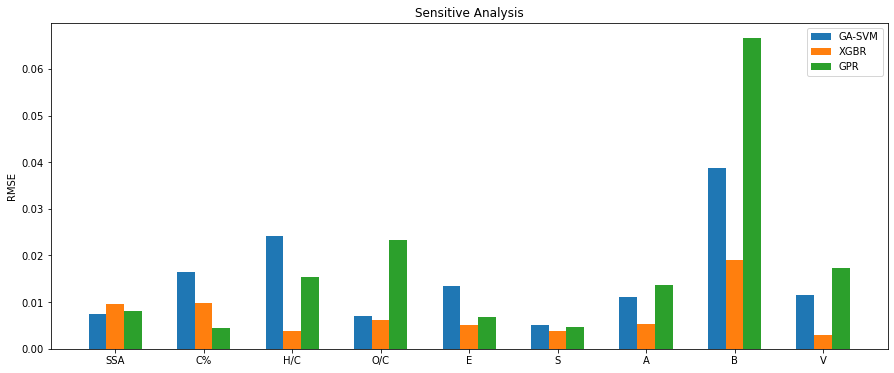

In [19]:
SA_GA_pred = SA_base_on_MSE(ga_svm,xx,yy)
SA_GPR_pred = SA_base_on_MSE(gpr,xx,yy)
SA_XGBR_pred = SA_base_on_MSE(xgbr,xx,yy)

x = np.arange(len(SA_GA_pred.index))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x-width, SA_GA_pred.values , width, label='GA-SVM')
rects2 = ax.bar(x, SA_XGBR_pred.values , width, label='XGBR')
rects3 = ax.bar(x + width, SA_GPR_pred.values, width, label='GPR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('Sensitive Analysis')
ax.set_xticks(x)
ax.set_xticklabels(SA_GA_pred.index)
ax.legend(loc='best')

# Sobol index with Scipy generate samples

In [21]:
bounds = pd.DataFrame(index=xx.columns,columns=['min','max'])
bounds['min'] = np.min(xx,0)
bounds['max'] = np.max(xx,0)
bounds

,min,max
SSA,0.000334,877.000000
C%,0.384000,1.000000
H/C,0.066667,1.111111
O/C,0.000000,32.000000
E,-0.830000,3.600000
S,-0.130000,2022.000000
A,0.000000,2.030000
B,0.000000,3.500000
V,0.864200,9.476000


In [22]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
from scipy.stats.qmc import Halton
import numpy as np

# Define the problem
problem = {
    'num_vars': len(xx.columns),
    'names': ['BET(m^2/g)', 'C%', 'H/C', 'O/C', 'E', 'S', 'A', 'B', 'V'],
    'bounds': bounds.values.astype('float')
}

# Generate the samples
N = 20480
halton = Halton(d=problem['num_vars'])
samples = halton.random(n=N)

# Perform analysis
Y_gpr2 = gpr.predict(samples) 
Y_svm2 = ga_svm.predict(samples) 
Y_xgbr2 = xgbr.predict(samples) 

Si_gpr2 = sobol.analyze(problem, Y_gpr2, print_to_console=True)
total_Si_gpr, first_Si_gpr, second_Si_gpr = Si_gpr2.to_df()

Si_svm2 = sobol.analyze(problem, Y_svm2, print_to_console=True)
total_Si_svm, first_Si_svm, second_Si_svm = Si_svm2.to_df()

Si_xgbr2 = sobol.analyze(problem, Y_xgbr2, print_to_console=True)
total_Si_xgbr, first_Si_xgbr, second_Si_xgbr = Si_xgbr2.to_df()

                  ST   ST_conf
BET(m^2/g)  0.718470  0.093943
C%          0.223083  0.029521
H/C         0.906157  0.115337
O/C         0.249409  0.027652
E           0.661732  0.069566
S           0.410961  0.048825
A           0.572887  0.082865
B           0.233968  0.024141
V           0.554690  0.076147
                  S1   S1_conf
BET(m^2/g) -0.433595  0.061329
C%         -0.387439  0.032814
H/C         0.430584  0.114770
O/C        -0.432051  0.039238
E           1.120777  0.080740
S          -0.485551  0.037955
A           0.596696  0.079286
B          -0.402461  0.044300
V          -0.381319  0.047352
                         S2   S2_conf
(BET(m^2/g), C%)   0.560054  0.063747
(BET(m^2/g), H/C)  0.547596  0.121870
(BET(m^2/g), O/C)  0.665730  0.078001
(BET(m^2/g), E)   -0.537398  0.075698
(BET(m^2/g), S)    0.695632  0.076806
(BET(m^2/g), A)   -0.501220  0.093242
(BET(m^2/g), B)    0.857826  0.082199
(BET(m^2/g), V)    0.443993  0.077835
(C%, H/C)         -0.561115  0.127757


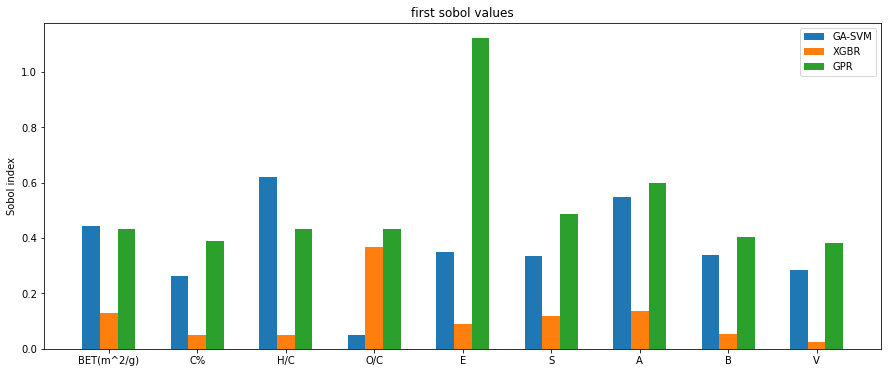

In [23]:
x = np.arange(len(total_Si_svm.index))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x-width, abs(first_Si_svm['S1']), width, label='GA-SVM')
rects2 = ax.bar(x, abs(first_Si_xgbr['S1']), width, label='XGBR')
rects3 = ax.bar(x+width, abs(first_Si_gpr['S1']), width, label='GPR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sobol index')
ax.set_title('first sobol values')
ax.set_xticks(x)
ax.set_xticklabels(total_Si_svm.index)
ax.legend(loc='best')

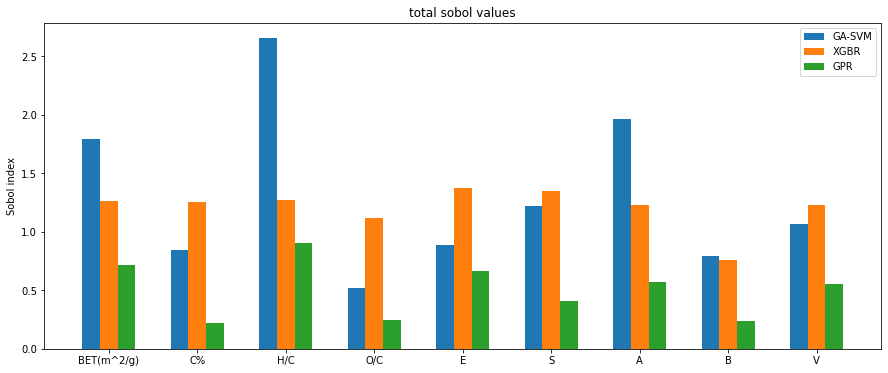

In [24]:
x = np.arange(len(total_Si_svm.index))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x-width, total_Si_svm['ST'], width, label='GA-SVM')
rects2 = ax.bar(x, total_Si_xgbr['ST'], width, label='XGBR')
rects3 = ax.bar(x+width, total_Si_gpr['ST'], width, label='GPR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sobol index')
ax.set_title('total sobol values')
ax.set_xticks(x)
ax.set_xticklabels(total_Si_svm.index)
ax.legend(loc='best')

In [26]:
df_sobol = pd.DataFrame(index=SA_GA_pred.index, columns = ['GPR','GA-SVM','XGB'])
df_sobol['GPR'] = total_Si_gpr['ST'].values
df_sobol['GA-SVM'] = total_Si_svm['ST'].values
df_sobol['XGB'] = total_Si_xgbr['ST'].values



# SHAP (SHapley Additive exPlanations)

In [27]:
df_shap = pd.DataFrame(index=xx.columns, columns = ['ga_svm','gpr','xgbr'])

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


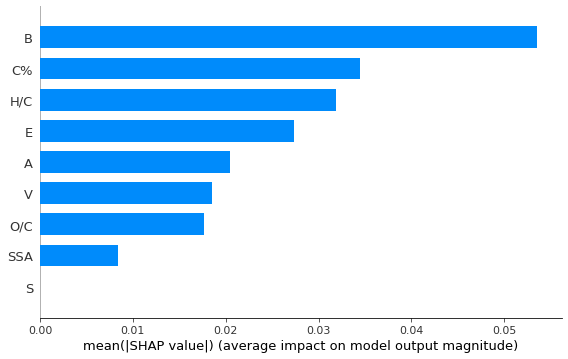

In [28]:
import shap

explainer = shap.KernelExplainer(ga_svm.predict, x_test)
shap_values_ga_svm = explainer.shap_values(x_test)
df_shap['ga_svm'] = np.average(abs(shap_values_ga_svm),0)
shap.summary_plot(shap_values_ga_svm,  xx, plot_type="bar")

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


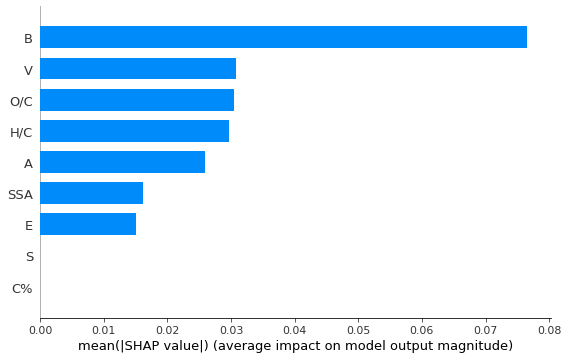

In [29]:
explainer = shap.KernelExplainer(gpr.predict,  x_test)
shap_values_gpr = explainer.shap_values(x_test)
# visualize the first prediction's explanation
df_shap['gpr'] = np.average(abs(shap_values_gpr),0)
shap.summary_plot(shap_values_gpr,  xx, plot_type="bar")

In [30]:
df_shap['gpr'] = np.average(abs(shap_values_gpr),0)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


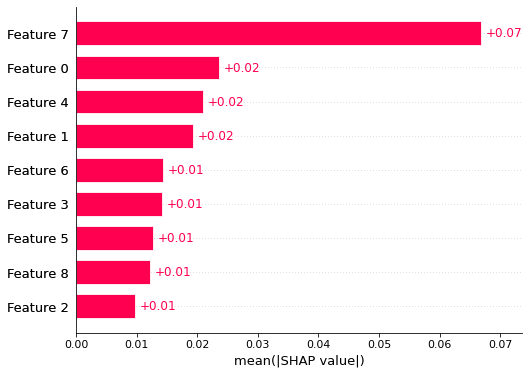

In [31]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgbr)
shap_values_xgr = explainer(x_test)
df_shap['xgbr'] = np.average(abs(shap_values_xgr.values),0)
# visualize the first prediction's explanation
shap.plots.bar(shap_values_xgr)

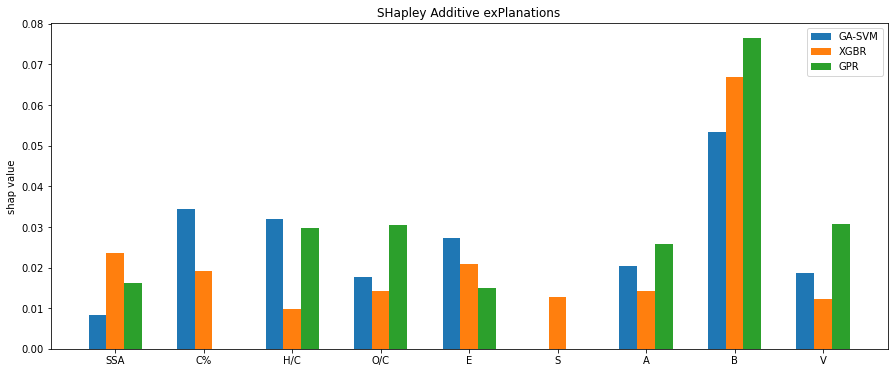

In [32]:
x = np.arange(len(df_shap.index))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 6))
rects1 = ax.bar(x-width, df_shap['ga_svm'], width, label='GA-SVM')
rects2 = ax.bar(x, df_shap['xgbr'], width, label='XGBR')
rects3 = ax.bar(x+width, df_shap['gpr'], width, label='GPR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('shap value')
ax.set_title('SHapley Additive exPlanations')
ax.set_xticks(x)
ax.set_xticklabels(df_shap.index)
ax.legend(loc='best')

In [33]:
df_shap

,ga_svm,gpr,xgbr
SSA,0.008433,0.016220,0.023532
C%,0.034466,0.000000,0.019271
H/C,0.031898,0.029675,0.009771
O/C,0.017619,0.030426,0.014177
E,0.027303,0.015023,0.020949
S,0.000017,0.000002,0.012643
A,0.020502,0.025879,0.014307
B,0.053497,0.076480,0.066804
V,0.018562,0.030766,0.012226
